In [1]:
%pylab
%matplotlib inline
rc('text', usetex = False)
import pandas as pd
import cosmoslik as cs
from cosmoslik_plugins.samplers.metropolis_hastings import load_chain
from scipy.stats import norm, chi2
import pickle

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
def like1d(data, weights, bins = 100):
    
    H, xe = histogram(data,bins,weights=weights,normed=False)
    xem = movavg(xe,2)
    fitdata = [[d]*w for d,w in zip(data, weights)]
    fitdata = [item for sublist in fitdata for item in sublist]
    mu, sigma = norm.fit(fitdata)
    maxval = max(norm.pdf(linspace(min(data), max(data), 10000), scale = sigma, loc = mu))
    return H, xem, mu, sigma, maxval

In [3]:
def likelihood(data, weights, bins = 100):
    
    H, xe = histogram(data,bins,weights=weights,normed=False)
    xem = movavg(xe,2)
    fitdata = [[d]*w for d,w in zip(data, weights)]
    fitdata = [item for sublist in fitdata for item in sublist]
    df, mu, sigma = chi2.fit(fitdata)
    maxval = max(chi2.pdf(df, linspace(min(data), max(data), 10000), scale = sigma, loc = mu))
    return H,  df, xem, mu, sigma, maxval

In [4]:
def get_data():
    '''
    Grabs the cepheids and sne from the R16 sample
    returns: 
        cepheids: Cepheid dataframe
        sne: sne dataframe
    '''
    filename = '../data/r16_table4.out'
    sne_start = 40
    sne_end = 59
    sne_lines = arange(sne_start,sne_end)
    sne = pd.DataFrame(columns = ['Host', 'sne', 'm^B_0', 'err'], index = arange(sne_end - sne_start))
    ceph_start = 70
    ceph_end = 2346
    cepheid_lines = arange(ceph_start,ceph_end)
    cepheids = pd.DataFrame(columns = ['Field','RA','DEC','ID','Period','VminusI','m_H','sigma_tot','Z'], 
                            index = arange(ceph_end - ceph_start),
                           dtype = 'float')
    f = file(filename)
    for i, line in enumerate(f):
        if i in sne_lines:
            sne.loc[i-sne_start] = line.lower().split()
        if i in cepheid_lines:
            cepheids.loc[i-ceph_start] = line.lower().split()

    f.close()
    cepheids = cepheids.apply(lambda x: pd.to_numeric(x, errors='ignore') );

    sne = sne.apply(lambda x: pd.to_numeric(x, errors='ignore') );


    parallaxes = {'bgcru': (2.23, 0.30,-0.15), 
                  'dtcyg':(2.19,0.33, -0.18), 
                  'ffaql':(2.64,0.16, -0.03),
                  'rtaur':(2.31, 0.19,-0.06),
                  'sscma':(0.348, 0.038, -0.04),
                  'sucas':(2.57,  0.33, -0.13 ),
                  'syaur':(0.428, 0.054, -0.04),
                  'tvul':(2.06,0.22,-0.09 ),
                  'wsgr':(2.30, 0.19, -0.06),
                  'xsgr':(3.17, 0.14, -0.02),
                  'ysgr':(2.13, 0.29, -0.15),
                  'betador':(3.26, 0.14, -0.02),
                  'delceph':(3.71,0.12,-0.01),
                  'etagem':(2.74,0.12,-0.02),
                  'lcar':(2.03,0.16,-0.05)
                 }
    parallaxes = pd.DataFrame.from_dict(parallaxes, orient = 'index', )
    parallaxes.reset_index(inplace=True)
    parallaxes.columns = ['ID', 'parallax', 'p_err', 'LK']
    cepheids = cepheids.merge(parallaxes, on = 'ID', how = 'left')


    cepheids.fillna({'parallax':1e-03, 'p_err':0, 'LK':0}, inplace = True);
    cepheids['err'] = sqrt(cepheids.sigma_tot**2 + (cepheids.p_err / cepheids.parallax * 5/log(10))**2)
    return cepheids, sne

In [5]:
cepheids, sne = get_data()

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,
         1.,  2.,  0.,  1.,  1.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.        ,  0.05128205,  0.1025641 ,  0.15384615,  0.20512821,
         0.25641026,  0.30769231,  0.35897436,  0.41025641,  0.46153846,
         0.51282051,  0.56410256,  0.61538462,  0.66666667,  0.71794872,
         0.76923077,  0.82051282,  0.87179487,  0.92307692,  0.97435897,
         1.02564103,  1.07692308,  1.12820513,  1.17948718,  1.23076923,
         1.28205128,  1.33333333,  1.38461538,  1.43589744,  1.48717949,
         1.53846154,  1.58974359,  1.64102564,  1.69230769,  1.74358974,
         1.79487179,  1.84615385,  1.8974359 ,  1.94871795,  2.        ]),
 <a list of 39 Patch objects>)

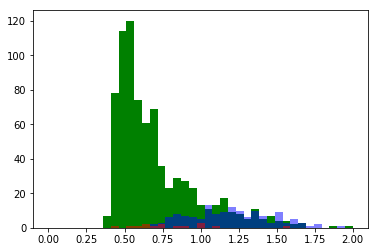

In [24]:
cepheids['logP'] = cepheids.Period.apply(log10)
ax = subplot(111)
hist(cepheids.loc[cepheids.Field == 'lmc', 'logP'], color = 'g',bins = linspace(0,2,40))
hist(cepheids.loc[cepheids.Field == 'n4258', 'logP'], color = 'b',bins = linspace(0,2,40), alpha = 0.5)
hist(cepheids.loc[cepheids.Field == 'galaxy', 'logP'], color = 'r',bins = linspace(0,2,40), alpha = 0.5)

#cepheids.groupby('Field').count()

In [6]:
burnins = 5000

In [8]:
# no_int_color = load_chain('varyR_nocolor_correction.chain').burnin(burnins).join()
# chain = no_int_color.copy().thin(18)
# chain.savechain('varyR_no_correction_thinned.chain')

In [5]:
#temp = load_chain('base_pop1.chain').burnin(3000).join()
#temp.like1d('H0')
temp = load_chain('base_pop2.chain').burnin(3000).join()
temp.like1d('H0', c = cmap(1), lw = 4)
temp = load_chain('base_pop3.chain').burnin(3000).join()
temp.like1d('H0', c = cmap(2), lw = 4)
#temp = load_chain('base_pop4.chain').burnin(3000).join()
#temp.like1d('H0', c = cmap(3))
temp = load_chain('base_pop5.chain').burnin(3000).join()
temp.like1d('H0', c = cmap(4), lw = 4)
temp = load_chain('base_pop6.chain').burnin(3000).join()
temp.like1d('H0', c = cmap(5), lw = 4)
multi_pop.like1d('H0', c = 'k', lw = 4)
#xlim(0, 200)
figure()
#temp.plot('lnl')
scatter(log10(cepheids.Period), cepheids.VminusI, s= 3, lw = 0, cmap = cmap, c = cepheids.Class)
colorbar(ticks = arange(n_classes))
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);

IOError: [Errno 2] No such file or directory: 'base_pop2.chain'

In [10]:
base = load_chain('../data/base.chain').burnin(burnins).join()

IOError: [Errno 2] No such file or directory: 'base.chain'

In [ ]:
multi_pop = load_chain('base_multi_pop.chain').burnin(burnins).join()


In [ ]:
varyR = load_chain('varyR.chain').burnin(burnins).join()

In [ ]:
widez = load_chain('base_widedz.chain').burnin(burnins).join()

In [ ]:
both = load_chain('varyR_manypops.chain').burnin(burnins).join()



In [ ]:
no_int_color.like2d('lnl', 'H0')
no_int_color.plot('lnl')
no_int_color.best_fit()['lnl']
#figure()
#base.like1d('lnl', nbins = 100)
#multi_pop.like1d('lnl',nbins = 100)
#widez.like1d('lnl', nbins = 100)



In [ ]:
both.savecov('trials.covmat')
no_int_color.plot()
no_int_color.savecov('varyR_no_int_color.covmat')

# Plot of $H_0$

In [ ]:
num_models = 6
cmap = cm.get_cmap('Paired', num_models)

In [ ]:
bins = linspace(65,85, 100)
x = linspace(65,82, 10000)
from scipy.stats import norm
H0R16 = norm(scale = 1.59, loc = 73.24)
#plot(x, H0R16.pdf(x)/max(H0R16.pdf(x)), label = r'${\rm R16 \, value}$', lw = 4,c = cmap(0))
## Base case
no_int_color.like1d('H0', label = r'${\rm R16 \, value}$', c = cmap(0), lw = 4)
base.like1d('H0', label = r'${\rm +(V-I)^0}$', lw = 4, nbins = 50,c = cmap(1))
multi_pop.like1d('H0', label = r'$+6 {\rm \, pop}$', lw = 4, nbins = 50,c = cmap(2))


# ## varyR
varyR.like1d('H0', label = r'$R(\theta) {\rm \, free}$', lw = 4, nbins = 50)
both.like1d('H0', label = r'$R(\theta) + {\rm pop.\, cut}$', lw = 4, nbins = 50,c = cmap(4))
# ## E(V-I) cut


## Planck
H0planck = norm(scale = 0.62, loc = 66.93)
plot(x, H0planck.pdf(x)/max(H0planck.pdf(x)), label = r'${\rm Planck  \, value}$', lw = 4,c = cmap(5))


ylabel(r'$\mathcal{P}(H_0)$', fontsize = 18)
xlabel(r'$H_0$', fontsize= 18)
xlim(64,82)
legend(frameon = False);

In [ ]:
from scipy.stats import norm

H_0 = []
bins = linspace(65,85, 100)
x = linspace(65,82, 10000)
fig, post_fig = subplots()
ylabel(r'$\mathcal{P}(H_0)$', fontsize = 18)
xlabel(r'$H_0$', fontsize= 18)
xlim(60,78)
ylim(0,1)
legend(frameon = False);

fig, box_fig = subplots()
xlim(60,78)
ylim(0,7)
xlabel(r'$H_0$', fontsize = 18)
yticks(arange(6), '')

H0R16 = norm(scale = 1.59, loc = 73.24)
post_fig.plot(x, H0R16.pdf(x)/max(H0R16.pdf(x)), label = r'${\rm R16}$', lw = 4,c = cmap(0))
box_fig.errorbar(73.24, 6, xerr = 2*1.59, fmt = 'o',c = cmap(0))
box_fig.errorbar(73.24, 6, xerr = 1.59, fmt = 'o',c = cmap(0))
box_fig.text(62, 6, r'${\rm R}16$', fontsize = 12)
print 'R16', 73.24, 1.59


## Base case
xem, H_0, mu, sigma, maxval = like1d(base['H0'], base['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'${\rm base}$', lw = 4,c = cmap(1))
box_fig.errorbar(mu, 5, xerr = 2*sigma, fmt = 'o',c = cmap(1))
box_fig.errorbar(mu, 5, xerr = sigma, fmt = 'o',c = cmap(1))


box_fig.text(62, 5, r'$(V-I)^0{\rm}$', fontsize = 12)
print 'base', mu, sigma


## many populations
xem, H_0, mu, sigma, maxval = like1d(multi_pop['H0'], multi_pop['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'$+{\rm Pop.\, weighting}$', lw = 4,c = cmap(2))
box_fig.errorbar(mu, 4, xerr = 2*sigma, fmt = 'o',c = cmap(2))
box_fig.errorbar(mu, 4, xerr = sigma, fmt = 'o',c = cmap(2))


box_fig.text(62, 4, r'$+{\rm Pop.\, Weighting}$', fontsize = 12)

print 'multi pop', mu, sigma



## many populations
xem, H_0, mu, sigma, maxval = like1d(varyR['H0'], varyR['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'$+{R(\theta)}$', lw = 4,c = cmap(2))
box_fig.errorbar(mu, 3, xerr = 2*sigma, fmt = 'o',c = cmap(3))
box_fig.errorbar(mu, 3, xerr = sigma, fmt = 'o',c = cmap(3))
box_fig.text(62, 3, r'$+R(\theta)$', fontsize = 12)

print 'multi pop', mu, sigma



## both
xem, H_0, mu, sigma, maxval = like1d(both['H0'], both['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'$+{\rm Pop.\, Weighting} + R(\theta)$', lw = 4,c = cmap(4))
box_fig.errorbar(mu, 2, xerr = 2*sigma, fmt = 'o',c = cmap(4))
box_fig.errorbar(mu, 2, xerr = sigma, fmt = 'o',c = cmap(4))


box_fig.text(62, 2,r'$+{\rm Pop.\, Weighting} + R(\theta)$', fontsize = 12)

print 'both', mu, sigma


## Planck
sigma = 0.62
mu = 66.93
H0planck = norm(scale = 0.62, loc = 66.93)
post_fig.plot(x, H0planck.pdf(x)/max(H0planck.pdf(x)), label = r'${\rm Planck}$', lw = 4,c = cmap(0))
box_fig.errorbar(mu, 1, xerr = 2*sigma, fmt = 'o',c = cmap(5))
box_fig.errorbar(mu, 1, xerr = sigma, fmt = 'o',c = cmap(5))


box_fig.text(62, 1, r'$ {\rm Planck}$', fontsize = 12)




#savefig('/Users/follin/Desktop/H_0post.pdf')
#.savefig('/Users/follin/Desktop/H_0posterior.pdf')

In [ ]:
from scipy.integrate import quad
from scipy.stats import norm
def pvalue(chain):
    fitdata = [[d]*w for d,w in zip(chain['H0'], chain['weight'])]
    fitdata = [item for sublist in fitdata for item in sublist]

    x = norm(scale = 0.62, loc = 66.93).rvs(size = len(fitdata))
    pval = sum([(x>y) for x,y in zip(x, fitdata)])*1.0/len(fitdata)
    z = norm.ppf(pval)
    return pval, z
print 'base case', pvalue(base)
print '6 populations', pvalue(multi_pop)
#print 'r free', pvalue(varyR)
print 'both', pvalue(both)
#print 'E(V-I) cut', pvalue(cutoff)

In [ ]:
# xvals = []
# xerr = []
# fields = []
# for field in ['lmc','n4258', 'm31',
#                   'm101', 'n5917', 'n4639', 
#                   'n3370', 'n3447', 
#                   'n1448', 'n5584', 'n2442', 
#                   'u9391', 'n3982', 
#                   'n1365', 'n7250', 'n1015', 
#                   'n4536', 'n3021', 
#                   'n3972', 'n1309', 'n4424', 
#                   'n4038']:
#     xvals += [varyR.mean('R_'+field) + 0.39]
#     xerr += [varyR.std('R_'+field)]
#     if field != 'galaxy':
#         fields += [field]
#     else:
#         fields +=['MW']
ax1 = subplot(111)
# xlim(-1, len(xvals))
# errorbar(arange(len(xvals)), xvals, yerr = xerr, fmt = 'o', label =  r'${\rm base}+ R_{x,\alpha}$')

xvals = []
xerr = []
fields = []
for field in ['lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']:
    xvals += [both.mean('R_'+field) + 0.39]
    xerr += [both.std('R_'+field)]
    if field != 'galaxy':
        fields += [field]
    else:
        fields +=['MW']

errorbar(arange(len(xvals)), xvals, yerr = xerr, fmt = '^', color = 'r', label =  r'$+{\rm no\, Pop\, A}$')

#plot(arange(25), ones(25)*sum(array(xvals) * array(xerr)/sum(xerr)), label = r'${\rm mean\, }R_H$')  
plot(arange(-1, 25), ones(26) * 0.39, lw = 4)
#legend( loc = 9, frameon = False)
xticks(arange(len(xvals)), fields, rotation='vertical');
#title(r'$R_H_{MW} \, {\rm free}$, \, $H_0 = 70.36 \pm 1.98$')
ylabel(r'$R_H$', fontsize = 18)
ylim(0.1, 0.7)
#fig.subplots_adjust(left = 0.2, bottom = 0.2, top = 0.95, right = 0.95)



ax = twinx(ax1)
fields = ['lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']
gridparams = ['H0'] + ['R_'+x for x in fields]
x = arange(len(gridparams))
#corr = pd.DataFrame(varyR.corr(gridparams), index = gridparams, columns = gridparams)
#corr.loc['H0','H0'] = 0

#plot(x-0.5,array(corr['H0']), ls = 'steps', lw = 4, c = 'b', alpha = 0.5)

corr = pd.DataFrame(both.corr(gridparams), index = gridparams, columns = gridparams)
corr.loc['H0','H0'] = 0

plot(x-0.5,array(corr['H0']), ls = 'steps', lw = 4, c = 'r', alpha = 0.5)


#xlim(-0.5, len(gridparams)-0.5);
ylim(-0.3+.01, 0.3+.01)
#plot([-1, 30], [0,0], lw = 4)
#ylabel(r'$\frac{\langle H_0 R_{H}^x\rangle}{\sqrt{\langle H_0^2\rangle \langle (R_H^x)^2 \rangle}}$', fontsize = 18)
ylabel(r'${\rm Corr}(R_H^x, H_0)$', fontsize = 18)
xlim(-0.5, len(fields)-0.5);
#savefig('/Users/fo/papers/local_hubble/FIGURES/MW_free.png')
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/R_H_by_field.pdf')

In [ ]:
both.like2d('H0', 'R_n4258')

In [ ]:
ax = subplot(111)
no_int_color.like2d('H0', 'dz', label = 'base', c = cmap(0/6), ax = ax)
base.like2d('H0', 'dz', c = cmap(2.0/6), label = 'multiple pops', ax = ax)
ax.legend()
xlabel(r'$H_0$', fontsize= 18)
ylabel(r'$dz$', fontsize = 18);
figure()
no_int_color.like1d('H0', c = cmap(0/6), lw = 4)
base.like1d('H0', c = cmap(2.0/6), lw = 4)

sigma = 0.62
mu = 66.93
H0planck = norm(scale = 0.62, loc = 66.93)
plot(x, H0planck.pdf(x)/max(H0planck.pdf(x)), label = r'${\rm Planck}$', lw = 4,c = cmap(4))
#box_fig.errorbar(mu, 1, xerr = 2*sigma, fmt = 'o',c = cmap(5))
#box_fig.errorbar(mu, 1, xerr = sigma, fmt = 'o',c = cmap(5))



In [ ]:
correlation = pd.DataFrame(both.corr(), columns = both.params(), index = both.params())
correlation['H0']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture

In [ ]:
cepheids['logP'] = log10(cepheids.Period)
features = cepheids[['logP', 'VminusI']]


In [ ]:
# bic_array = []
# for n_classes in arange(1,15):
#     model = GaussianMixture(n_components = n_classes, max_iter = 1000, n_init = 1000, init_params= 'random')
#     estimate = model.fit(features)
#     bic_array += [model.bic(features)]
# scatter(arange(1,15), bic_array)
# xlim(0,16)

In [ ]:
# n_classes = 6
# f = open('gaussian_mixture_model', 'w')
# model = GaussianMixture(n_components = n_classes, max_iter = 1000, n_init = 1000, init_params= 'random')
# model.fit(features)
# pickle.dump(model, f)
# f.close()

In [ ]:
n_classes = 6
f = open('gaussian_mixture_model', 'r')
model = pickle.load(f)
f.close()
cmap = cm.get_cmap('Paired', n_classes)

In [ ]:
probs = model.predict_proba(features)
for pop in arange(6):
    print 'population '+str(pop+1)+' cepheids:',  sum(probs, axis = 0)[pop]


In [ ]:
scatter(cepheids['logP'], cepheids.VminusI, s = 3, c= 'k', lw = 0)
ylim(0,3)
xlim(0,2.5);
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18)

In [ ]:
num_samples = 400
model.covariances_
from scipy.stats import multivariate_normal as norm
xvals = []
yvals = []
pop = []
pdf = norm(mean = model.means_[0], cov = model.covariances_[0,:,:])
vals = pdf.rvs(num_samples)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [0]*num_samples


pdf = norm(mean = model.means_[1], cov = model.covariances_[1,:,:])
vals = pdf.rvs(num_samples)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [1]*num_samples

pdf = norm(mean = model.means_[2], cov = model.covariances_[2,:,:])
vals = pdf.rvs(num_samples)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [2]*num_samples

pdf = norm(mean = model.means_[3], cov = model.covariances_[3,:,:])
vals = pdf.rvs(num_samples)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [3]*num_samples

pdf = norm(mean = model.means_[4], cov = model.covariances_[4,:,:])
vals = pdf.rvs(num_samples)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [4]*num_samples

pdf = norm(mean = model.means_[5], cov = model.covariances_[5,:,:])
vals = pdf.rvs(num_samples)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [5]*num_samples

scatter(xvals, yvals, cmap = cmap , c = pop, s = 3, lw = 0);
colorbar(ticks = arange(n_classes))
ylim(0,3)
xlim(0,2.5);
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);

In [ ]:
cepheids['Class'] = model.predict(features)
probs = model.predict_proba(features)

In [ ]:
scatter(log10(cepheids.Period), cepheids.VminusI, s= 3, lw = 0, cmap = cmap, c = cepheids.Class)
colorbar(ticks = arange(n_classes))
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);

In [ ]:
scatter(log10(cepheids.Period), cepheids.m_H, s= 3, lw = 0, cmap = cmap, c = cepheids.Class)
colorbar(ticks = arange(n_classes))
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'${\rm mag}$', fontsize = 18);

In [ ]:

fields = ['galaxy','lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']

groups = cepheids.groupby(['Field', 'Class'])
yvals = groups.count()['m_H'][fields]
which_field = yvals.index.labels[0]
which_cluster = yvals.index.labels[1]
xvals = yvals[which_cluster ==1].index.levels[0].tolist()
xvals[0] = 'MW'
xlabels = xvals
which_field = yvals[which_cluster ==0].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 0], color = cmap(0), alpha = 0.5,label = r'${\rm Pop\, 1}$')
which_field = yvals[which_cluster ==1].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 1], color = cmap(1.0/6), alpha = 0.5,label = r'${\rm Pop\, 2}$')
which_field = yvals[which_cluster ==2].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 2],color = cmap(2.0/6),  alpha = 0.5,label = r'${\rm Pop\, 3}$')
which_field = yvals[which_cluster ==3].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 3], color = cmap(3.0/6), alpha = 0.5,label = r'${\rm Pop\, 4}$')
which_field = yvals[which_cluster ==4].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 4], color = cmap(4.0/6), alpha = 0.5,label = r'${\rm Pop\, 5}$')
which_field = yvals[which_cluster ==5].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 5], color = cmap(5.0/6), alpha = 0.5,label = r'${\rm Pop\, 6}$')






# for x,y in zip(arange(len(xlabels))[which_field], yvals[which_cluster == 4]):
#     text(x-0.25,y+10,'%3.0f'%y)

ylim(0,300);
#gca().set_yscale("log", nonposy='clip')
#ylim(1e-1,1.0e3)
ylabel(r'${\rm number\,\, of\,\, Cepheids}$', fontsize = 18)
xticks(arange(len(xlabels)) + 0.5, xlabels, rotation = 'vertical');
#gca().yaxis.set_ticklabels(['','','$1$', '$10$', '$100$', '$1000$'])
xlim(-0.1, len(xlabels));
legend();
#savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/popAB_distribution.pdf')

In [ ]:
both['M_ceph0']#+
both['M_ceph'+str(pop]

In [ ]:
vals = []

s


pd.Series(vals).std()/mean(vals)

In [ ]:
from model_manypops import Model

In [ ]:
for key in multi_pop.best_fit().keys():
    x[key] = multi_pop.best_fit()[key]

In [ ]:
x = Model(multiple_pops=True)
x.cepheids.Prob_0 = 0
x.cepheids.Prob_1 = 1
x.cepheids.Prob_2 = 0
x.cepheids.Prob_3 = 0
x.cepheids.Prob_4 = 0
x.cepheids.Prob_5 = 0 
for key in multi_pop.best_fit().keys():
    x[key] = multi_pop.best_fit()[key]


x.sampler

In [ ]:
both['Mceph0'] = both['M_ceph0']
params = ['Mceph'+x for x in arange(6).astype('str')] + ['H0']
print params
both.likegrid(params = params)
pd.DataFrame(both.corr(params = params), columns = params, index = params)

In [ ]:
arange(6).astype('str') + 'C0'

In [ ]:
temp.plot()